
# Robustness Plots for toy data sets
We compare the standard training of small ResNets with **robust training**.  
The augmented training is done by adding an extra term to the loss function with the goal to decrease sensitivity with respect to input data perturbations. As the extra term we take the gradient of the standard loss function with respect to the input.

In [19]:


# Standard libraries

import seaborn as sns
from matplotlib.colors import to_rgba, to_rgb
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import imageio
import math
import torch
import torch.nn as nn

# Predefined ResNet structures


from models.neural_odes import NeuralODE, grad_loss_inputs
from models.training import Trainer, epslinTrainer

from torch.utils import data as data
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler


# Progress bar
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Imports for Jupyter display

# For export. Makes the plots size right for the screen
%config InlineBackend.figure_formats = ['svg'] 
%matplotlib inline


#random seed
torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)


#quite fixed variables

#as we look at ResNet in dim 2 this is fixed
hidden_dim, data_dim = 2, 2

# 20 before  #T is the end time, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5.0, 2
dt = T/num_steps
turnpike = False

bound = 0.
fp = False
cross_entropy = True

shuffle = False

if turnpike:
    weight_decay = 0 if bound > 0. else dt*0.01
else:
    weight_decay = dt*0.01  # 0.01 for fp, 0.1 else

# Prepare Datasets

In [20]:
def create_dataloader(data_type, batch_size = 3000, noise = 0.15, factor = 0.15, random_state = 1, shuffle = False):
    if data_type == 'circles':
        X, y = make_circles(3000, noise=noise, factor=factor, random_state=random_state, shuffle = shuffle)
        
        
    elif data_type == 'blobs':
        centers = [[-1, -1], [1, 1]]
        X, y = make_blobs(
    n_samples=750, centers=centers, cluster_std=noise, random_state=0)
        
        
    elif data_type == 'xor':
        X = torch.randn(3000, 2)
        y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).float()
        # y = y.to(torch.int64)
        X += noise * torch.randn(X.shape)
        
        
    else: print('datatype not supported')

    g = torch.Generator()
    g.manual_seed(random_state)
    
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05 ) #random_state=2, shuffle = shuffle)

    X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
    y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

    X_test = torch.Tensor(X_test) # transform to torch tensor for dataloader
    y_test = torch.Tensor(y_test) #transform to torch tensor for dataloader

    X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
    y_train = y_train.type(torch.int64) #dtype of original picle.load data

    X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
    y_test = y_test.type(torch.int64) #dtype of original picle.load data


    train_data = TensorDataset(X_train,y_train) # create your datset
    test_data = TensorDataset(X_test, y_test)

    train = DataLoader(train_data, batch_size=64, shuffle=shuffle, generator=g)
    test = DataLoader(test_data, batch_size=128, shuffle=shuffle, generator = g)
    
    return train, test




train, test = create_dataloader('xor')



# Define Plot

In [25]:
@torch.no_grad()
def visualize_classification(model, data, label, grad = None, fig_name=None, footnote=None, contour = True, x1lims = [-2, 2], x2lims = [-2, 2]):
    
    
    x1lower, x1upper = x1lims
    x2lower, x2upper = x2lims

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(5, 4), dpi=300)
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0", zorder = 1)
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1", zorder = 1)

    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, -0.05, footnote, ha="center", fontsize=10)
    # plt.legend()
    if torch.any(grad):
        for i in range(len(data[:, 0])):
            plt.arrow(data[i, 0], data[i, 1], grad[i, 0], grad[i, 1],
                    head_width=0.05, head_length=0.1, fc='k', ec='k', alpha=0.5)

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    # creates the RGB values of the two scatter plot colors.
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)

    

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds, _ = model(model_inputs)
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    # now we only want to have the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    # Specifying "None" in a dimension creates a new one. The rgb values hence get rescaled according to the prediction
    output_image = (1 - preds) * c1[None, None] + preds * c0[None, None]
    # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    output_image = output_image.cpu().numpy()
    plt.imshow(output_image, origin='lower', extent=(x1lower, x1upper, x2lower, x2upper), zorder = -1)
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])
    

    # labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.numpy()]
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is black, last is red
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        # plt.contourf(xx2, xx1, z, [0.3, 0.70], colors = ('w',), alpha = 0.3, zorder = 0)
        plt.contourf(xx1, xx2, z, alpha=1, cmap=cm, zorder = 0) #plt.get_cmap('coolwarm')
        




    # preds_contour = preds.view(len(x1), len(x1)).detach()
    # plt.contourf(xx1, xx2, preds_contour, alpha=1)

    plt.savefig('test', bbox_inches='tight', dpi=300, format='png')
    return fig

# Training

In [26]:
# Plot variables

save_model = False  # train new network or load saved one
pretrained = False
num_epochs = 80  # 80 #number of optimization epochs for gradient decent

# model and training parameters

epsilons = [0]
# epsilons = [0 , 0.01,  0.1] #0.2, 0.5, 0.7]#, 0.01, 0.1, 0.5]#, 0.0001, 0.0002]#, 0.0001, 0.001, 0.01]
non_linearity = 'tanh'  # 'sigmoid' #'tanh'
architecture = 'inside'  # outside #bottleneck

# data
xornoise = 0.2
data_noise = 0.2 # 0.05 before


# plots
fig_name = '1alingen'
plot_steps = 0  # 0 means only one plot is generated. plot_steps >0 means each plot_steps epochs one plot is generated

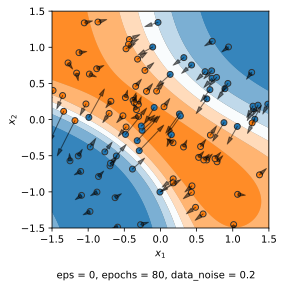

In [27]:
sort_num = 1

train_xor_loader, test_xor_loader = create_dataloader('xor')

for eps in epsilons:

    # torch.manual_seed(2)

    eps_node = NeuralODE(device, data_dim, hidden_dim, adjoint=False, augment_dim=0, non_linearity=non_linearity,
                         architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
    if pretrained:
        eps_node.load_state_dict(torch.load('rob_node.pth'))


    optimizer_node = torch.optim.Adam(eps_node.parameters(
    ), lr=1e-3, weight_decay=weight_decay)  # weight decay parameter modifies norm
    trainer_eps_node = epslinTrainer(eps_node, optimizer_node, device, cross_entropy=cross_entropy,
                                     turnpike=turnpike, bound=bound, fixed_projector=fp, verbose=False, eps=eps)

    if plot_steps == 0:
        plot_steps = num_epochs

    for h, i in enumerate(range(1, num_epochs+1, plot_steps)):

        trainer_eps_node.train(train_xor_loader, plot_steps)

        fig_name_plot = fig_name + \
            str(sort_num) + '_' + str(eps).replace('.', 'p') + '_' + str(h)

        for x_batch, y_batch in test_xor_loader:
            loss = trainer_eps_node.loss_func
            grad = grad_loss_inputs(eps_node, x_batch, y_batch, loss)
            grad = 10 * grad

            footnote = 'eps = {}, epochs = {}, data_noise = {}'.format(
                eps, num_epochs, xornoise)
            visualize_classification(eps_node, x_batch, y_batch, grad, 'new' + fig_name_plot, footnote = footnote, x1lims = [-1.5, 1.5], x2lims = [-1.5, 1.5])
            # plot_decision_boundary(x_batch, y_batch, eps_node)
            plt.show()
            break
        sort_num += 1